<a href="https://colab.research.google.com/github/MGyuyu/ADE-PINN-Masters-Thesis-Code/blob/main/PINN_2D_ADE_Forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=f2ac2260ec3cd512530f802d20b84a9dfa80268a3805e591b63347b1644662af
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
#@title Imports forward
import sys
import os
import time
from datetime import datetime
import tensorflow as tf
import numpy as np
import scipy.io
import tensorflow_probability as tfp
from pyDOE import lhs

import matplotlib
from scipy.io import savemat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Imports related to animations
import matplotlib.animation
from IPython.display import HTML

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

In [16]:
def prep_data(path, N_u=None, N_f=None, ub=None, lb=None, noise=0.0):
    # 读取外部数据
    data = scipy.io.loadmat(path)

    # 提取坐标和时间数组
    t = data['timesteps'].flatten()[:,None]  # T x 1
    y = data['y'].flatten()[:,None]  # N x 1
    x = data['x'].flatten()[:,None]  # N x 1

    # 打印一些信息来帮助调试
    print(f"加载数据: x形状 {x.shape}, y形状 {y.shape}, t形状 {t.shape}")

    # 检测并加载正确的解决方案数据
    if 'u' in data:
        Exact_u = np.real(data['u'])  # 假设是版本4，格式为[y, x, 时间]
        print(f"原始u形状: {Exact_u.shape}")
    elif 'u4' in data:
        Exact_u = np.real(data['u4'])
        print(f"原始u4形状: {Exact_u.shape}")
    else:
        raise ValueError("未找到预期的解决方案数据'u'或'u4'")

    # 网格化x、y、t为3D网格 (注意Python的meshgrid与MATLAB不同)
    X, Y, T = np.meshgrid(x, y, t)

    # 准备预测输入x和t（网格化为X, T）为单个数组X_star
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

    # 准备测试数据u_star
    # 如果Exact_u是[y, x, 时间]格式，swapaxes会将其转换为[x, y, 时间]
    u_star = np.swapaxes(Exact_u, 0, 1)
    print(f"转置后u_star形状: {u_star.shape}")
    u_star = u_star.flatten()[:,None]

    # 域边界（下界上界）[x, y, t]
    # 确保lb和ub是数组
    if lb is None:
        lb = X_star.min(axis=0)
    else:
        lb = np.array(lb) if isinstance(lb, (list, tuple)) else lb

    if ub is None:
        ub = X_star.max(axis=0)
    else:
        ub = np.array(ub) if isinstance(ub, (list, tuple)) else ub

    # 根据打印的边界值，手动设置正确的边界
    if not isinstance(lb, np.ndarray) or not isinstance(ub, np.ndarray):
        print("警告：边界值不是数组，使用默认值")
        lb = np.array([-2.0, -2.0, 0.0])
        ub = np.array([2.0, 2.0, 2.0])

    # 获取初始条件(t=0)
    xx1 = np.hstack((X[:,:,0:1].flatten()[:,None], Y[:,:,0:1].flatten()[:,None], T[:,:,0:1].flatten()[:,None]))
    uu1 = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])[:,:,0:1].flatten()[:,None]

    # 获取最低边界条件(x=0)
    xx2 = np.hstack((X[0:1,:,:].flatten()[:,None], Y[0:1,:,:].flatten()[:,None], T[0:1,:,:].flatten()[:,None]))
    uu2 = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])[0:1,:,:].flatten()[:,None]

    # 获取最高边界条件(x=1)
    xx3 = np.hstack((X[-1:,:,:].flatten()[:,None], Y[-1:,:,:].flatten()[:,None], T[-1:,:,:].flatten()[:,None]))
    uu3 = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])[-1:,:,:].flatten()[:,None]

    # 获取最低边界条件(y=0)
    xx4 = np.hstack((X[:,0:1,:].flatten()[:,None], Y[:,0:1,:].flatten()[:,None], T[:,0:1,:].flatten()[:,None]))
    uu4 = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])[:,0:1,:].flatten()[:,None]

    # 获取最高边界条件(y=1)
    xx5 = np.hstack((X[:,-1:,:].flatten()[:,None], Y[:,-1:,:].flatten()[:,None], T[:,-1:,:].flatten()[:,None]))
    uu5 = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])[:,-1:,:].flatten()[:,None]

    # 将它们堆叠到多维张量中进行训练(X_u_train现在是连续边界)
    X_u_train = np.vstack([xx1, xx2, xx3, xx4, xx5])
    u_train = np.vstack([uu1, uu2, uu3, uu4, uu5])

    # 使用拉丁超立方抽样生成散点
    X_f_train = lb + (ub-lb)*lhs(3, N_f)

    # 从整体数据中随机选择N_u个点作为训练数据
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx,:]
    u_train = u_train[idx,:]

    # 打印一些额外的调试信息
    print(f"X_star形状: {X_star.shape}, u_star形状: {u_star.shape}")
    print(f"X_u_train形状: {X_u_train.shape}, u_train形状: {u_train.shape}")
    print(f"X_f_train形状: {X_f_train.shape}")
    print(f"边界: lb = {lb}, ub = {ub}")

    # 可选：验证数据
    print("\n数据验证:")
    print(f"X形状: {X.shape}, Y形状: {Y.shape}, T形状: {T.shape}")
    u_reshaped = u_star.reshape(x.shape[0], y.shape[0], t.shape[0])
    print(f"重整形后的u_star形状: {u_reshaped.shape}")
    print(f"u_star的值范围: [{u_star.min()}, {u_star.max()}]")

    return x, y, t, X, Y, T, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

In [4]:
#@title Extract data from PINN
def ExtractData(pinn, X_star, X_u_train, u_star):

  # Getting the model predictions, over dense (x,y,t) domain
  X_star_batches = np.array_split(X_star,100)
  u_pred, _ = pinn.predict(X_star_batches[0])
  for i in range(len(X_star_batches)-1):
    u_pred_batch, _ = pinn.predict(X_star_batches[i+1])
    u_pred = np.vstack((u_pred,u_pred_batch))

  # Getting the model prediction, over training (x,y,t)
  X_u_train_batches = np.array_split(X_u_train,100)
  u_train_pred, _ = pinn.predict(X_u_train_batches[0])
  for i in range(len(X_u_train_batches)-1):
    u_train_batch, _ = pinn.predict(X_u_train_batches[i+1])
    u_train_pred = np.vstack((u_train_pred,u_train_batch))

  u_train_pred = u_train_pred.flatten()[:,None]

  N_x = x.shape[0]
  N_y = y.shape[0]
  N_t = t.shape[0]

  X_plot = X_star.reshape(N_x,N_y,N_t,3)
  u_plot = u_pred.reshape(N_x,N_y,N_t)
  u_star_plot = u_star.reshape(N_x,N_y,N_t)
  X_test = X_plot[:,:,0,0]
  Y_test = X_plot[:,:,0,1]

  trained_weights = pinn.get_weights()

  return X_test, Y_test, u_star_plot, u_plot, u_train_pred, trained_weights

In [5]:
#@title Discrete plotter
def DiscretePlotter(t,X_test,Y_test,u_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow'):

    def figsize(scale, nplots = 1):
        fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
        inches_per_pt = 1.0/72.27                       # Convert pt to inch
        golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
        fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
        fig_height = nplots*fig_width*golden_mean              # height in inches
        fig_size = [fig_width,fig_height]
        return fig_size

    # I make my own newfig and savefig functions
    def newfig(width, nplots = 1):
        fig = plt.figure(figsize=figsize(width, nplots))
        ax = fig.add_subplot(111)
        return fig, ax

    N_t = t.shape[0]
    Lt = ub[2]
    t0 = 0; t1 = Lt/5; t2 = 2*Lt/5; t3 = 3*Lt/5; t4 = 4*Lt/5; t5 = 5*Lt/5;
    N0 = int(np.ceil((t0*N_t)/Lt))
    N1 = int(np.ceil((t1*N_t)/Lt))
    N2 = int(np.ceil((t2*N_t)/Lt))
    N3 = int(np.ceil((t3*N_t)/Lt))
    N4 = int(np.ceil((t4*N_t)/Lt))
    N5 = int(np.floor((t5*N_t-1)/Lt))

    fig, ax = newfig(3.0, 3.0)
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(2, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N0], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('$t = 0.0$', fontsize = 10)
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N1], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.2$', fontsize = 10)

    ax = plt.subplot(gs1[0, 2])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N2], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.4$', fontsize = 10)

    ax = plt.subplot(gs1[1, 0])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N3], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('$t = 0.6$', fontsize = 10)
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[1, 1])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N4], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.8$', fontsize = 10)

    ax = plt.subplot(gs1[1, 2])
    ax.pcolor(X_test, Y_test, u_plot[:,:,N5], cmap='rainbow', vmin=zmin, vmax=zmax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.axis('square')
    #ax.set_xlim([-1.1,1.1])
    #ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 1.0$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    plt.show()

In [17]:
def TrainingDataPlotterForward(X_u_train, X_f, ub, lb):
    # 确保lb和ub是数组
    if not isinstance(lb, np.ndarray) or len(lb) < 2:
        lb = np.array([-2.0, -2.0, 0.0])
    if not isinstance(ub, np.ndarray) or len(ub) < 2:
        ub = np.array([2.0, 2.0, 2.0])

    print(f"绘图使用的边界: lb = {lb}, ub = {ub}")

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X_f[:,0], X_f[:,1], X_f[:,2], s=0.2, marker='x')
    ax.scatter(X_u_train[:,0], X_u_train[:,1], X_u_train[:,2], s=0.2, marker='o', alpha=0.8)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')

    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(X_f[:,0], X_f[:,1], s=0.2, marker='x')
    ax.scatter(X_u_train[:,0], X_u_train[:,1], s=0.2, marker='o', alpha=0.8)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(lb[0], ub[0])
    ax.set_ylim(lb[1], ub[1])

    plt.show()

    print('数据点总数: ' + str(X_u_train.shape[0] + X_f.shape[0]))

In [7]:
#@title Logger class
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%H:%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, current_best_loss, custom=""):
        if epoch % self.frequency == 0:
            print(f"{'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, loss, current_best_loss, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)
        print('Applying the weights at the best epoch to the model...')

In [8]:
#@title Loss and parameter plotter
def LossParameterPlotterForward(loss_history):
    plt.figure(figsize=(18,6))
    plt.suptitle('Training Metrics')

    plt.ylabel("Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.semilogy(loss_history)

    plt.show()

In [9]:
#@title LBFGS
# Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
    global global_time_list, global_last_time
    global_time_list = []
    global_last_time = time.perf_counter()

def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()
    #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a*b)

def verbose_func(s):
    print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
    """port of lbfgs.lua, using TensorFlow eager mode.
    """

    if config.maxIter == 0:
        return

    global final_loss, times

    maxIter = config.maxIter
    maxEval = config.maxEval or maxIter*1.25
    tolFun = config.tolFun or 1e-5
    tolX = config.tolX or 1e-19
    nCorrection = config.nCorrection or 100
    lineSearch = config.lineSearch
    lineSearchOpts = config.lineSearchOptions
    learningRate = config.learningRate or 1
    isverbose = config.verbose or False

    # verbose function
    if isverbose:
        verbose = verbose_func
    else:
        verbose = lambda x: None

    # evaluate initial f(x) and df/dx
    f, g = opfunc(x)

    f_hist = [f]
    currentFuncEval = 1
    state.funcEval = state.funcEval + 1
    p = g.shape[0]

    # check optimality of initial point
    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <= tolFun:
        verbose("optimality condition below tolFun")
        return x, f_hist

    # optimize for a max of maxIter iterations
    nIter = 0
    times = []
    while nIter < maxIter:
        start_time = time.time()

        # keep track of nb of iterations
        nIter = nIter + 1
        state.nIter = state.nIter + 1

        ############################################################
        ## compute gradient descent direction
        ############################################################
        if state.nIter == 1:
            d = -g
            old_dirs = []
            old_stps = []
            Hdiag = 1
        else:
            # do lbfgs update (update memory)
            y = g - g_old
            s = d*t
            ys = dot(y, s)

            if ys > 1e-10:
                # updating memory
                if len(old_dirs) == nCorrection:
                    # shift history by one (limited-memory)
                    del old_dirs[0]
                    del old_stps[0]

                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)

                # update scale of initial Hessian approximation
                Hdiag = ys/dot(y, y)

            # compute the approximate (L-BFGS) inverse Hessian
            # multiplied by the gradient
            k = len(old_dirs)

            # need to be accessed element-by-element, so don't re-type tensor:
            ro = [0]*nCorrection
            for i in range(k):
                ro[i] = 1/dot(old_stps[i], old_dirs[i])


            # iteration in L-BFGS loop collapsed to use just one buffer
            # need to be accessed element-by-element, so don't re-type tensor:
            al = [0]*nCorrection

            q = -g
            for i in range(k-1, -1, -1):
                al[i] = dot(old_dirs[i], q) * ro[i]
                q = q - al[i]*old_stps[i]

            # multiply by initial Hessian
            r = q*Hdiag
            for i in range(k):
                be_i = dot(old_stps[i], r) * ro[i]
                r += (al[i]-be_i)*old_dirs[i]

            d = r
            # final direction is in r/d (same object)

        g_old = g
        f_old = f

        ############################################################
        ## compute step length
        ############################################################
        # directional derivative
        gtd = dot(g, d)

        # check that progress can be made along that direction
        if gtd > -tolX:
            verbose("Can not make progress along direction.")
            break

        # reset initial guess for step size
        if state.nIter == 1:
            tmp1 = tf.abs(g)
            t = min(1, 1/tf.reduce_sum(tmp1))
        else:
            t = learningRate


        # optional line search: user function
        lsFuncEval = 0
        if lineSearch and isinstance(lineSearch) == types.FunctionType:
            # perform line search, using user function
            f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
            f_hist.append(f)
        else:
            # no line search, simply move with fixed-step
            x += t*d

            if nIter != maxIter:
                # re-evaluate function only if not in last iteration
                # the reason we do this: in a stochastic setting,
                # no use to re-evaluate that function here
                f, g = opfunc(x)
                lsFuncEval = 1
                f_hist.append(f)


        # update func eval
        currentFuncEval = currentFuncEval + lsFuncEval
        state.funcEval = state.funcEval + lsFuncEval

        ############################################################
        ## check conditions
        ############################################################
        if nIter == maxIter:
            break

        if currentFuncEval >= maxEval:
            # max nb of function evals
            verbose('max nb of function evals')
            break

        tmp1 = tf.abs(g)
        if tf.reduce_sum(tmp1) <=tolFun:
            # check optimality
            verbose('optimality condition below tolFun')
            break

        tmp1 = tf.abs(d*t)
        if tf.reduce_sum(tmp1) <= tolX:
            # step size below tolX
            verbose('step size below tolX')
            break

        if tf.abs(f-f_old) < tolX:
            # function value changing less than tolX
            verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
            break

        if do_verbose:
            log_fn(nIter, f.numpy(), True)
            #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
            record_time()
            times.append(last_time())

        if nIter == maxIter - 1:
            final_loss = f.numpy()


    # save state
    state.old_dirs = old_dirs
    state.old_stps = old_stps
    state.Hdiag = Hdiag
    state.g_old = g_old
    state.f_old = f_old
    state.t = t
    state.d = d

    return x, f_hist, currentFuncEval

In [10]:
#@title LBFGS structs
# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

In [18]:
#@title LBFGS v2
def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times

  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()

    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)

      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])


      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]

      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f

    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break

    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break

    # 这里是修复的部分，将逗号改为减号
    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)


In [12]:
#@title PINN forward w/ Adaptive param (Adaptive weights disabled)
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, ub, lb, f_param, u_param, activation_func=tf.keras.activations.tanh):
        # Descriptive Keras model [3, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(
          lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            self.u_model.add(tf.keras.layers.Dense(
              width, activation=activation_func,
              kernel_initializer='glorot_normal'))
        self.u_model.add(tf.keras.layers.Dense(
              layers[-1], activation=tf.keras.activations.linear,
              kernel_initializer='glorot_normal'))

        self.dtype = tf.float32
        self.loss_history = []
        self.f_param = f_param
        self.u_param = u_param
        self.current_best_loss = 1e10
        self.current_best_weights = []

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))


        self.optimizer = optimizer
        self.logger = logger

        self.beta = 0.01 # Default 0.1
        self.adaptive_param = 1.0
        self.adaptive_param_hat = 1.0
        self.adaptive_param_history = []

    # The actual PINN
    def __f_model(self, X_f):

        # Separating the collocation coordinates
        x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        y_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
        t_f = tf.convert_to_tensor(X_f[:, 2:3], dtype=self.dtype)

        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)
            # Packing together the inputs
            X_f = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)

            # Getting the prediction
            u = self.u_model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, x_f)
            u_y = tape.gradient(u, y_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, x_f)
        u_yy = tape.gradient(u_y, y_f)
        u_t = tape.gradient(u, t_f)

        # Letting the tape go
        del tape

        PDE = u_t + 2.0*u_x + (3.0*tf.math.cos(3.0*np.pi*t_f)+1.0)*u_y - 0.2*u_xx - 0.2*u_yy - 1.0*tf.math.exp(-4.0*(tf.math.square(x_f + 1.4)+tf.math.square(y_f + 1.0)))
        # Buidling the PINNs
        return PDE

    def __loss(self, X_f, X_u, u, u_pred):
        f_pred = self.__f_model(X_f)
        loss_f = tf.reduce_mean(tf.square(f_pred))
        loss_u = tf.reduce_mean(tf.square(u - u_pred))
        return loss_u, loss_f

    def __grad(self, X_f, X_u, u):
        with tf.GradientTape() as tape:
            loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
            loss_value = self.adaptive_param*loss_u + 1.0*loss_f                          # Use adaptive param
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __adaptive_param(self, X_f, X_u, u):
        with tf.GradientTape(persistent=True) as tape:
            loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
            grad_u = tape.gradient(self.adaptive_param*loss_u, self.__wrap_training_variables(), unconnected_gradients=tf.UnconnectedGradients.ZERO)
            grad_f = tape.gradient(loss_f, self.__wrap_training_variables(), unconnected_gradients=tf.UnconnectedGradients.ZERO)
        del tape

        grad_f_flatten = []
        grad_u_flatten = []
        for g in grad_f:
            grad_f_flatten.append(tf.reshape(g,[-1]))
        grad_f_flatten = tf.concat(grad_f_flatten,0)
        for g in grad_u:
            grad_u_flatten.append(tf.reshape(g,[-1]))
        grad_u_flatten = tf.concat(grad_u_flatten,0)


        max_grad_f = tf.reduce_max(tf.abs(grad_f_flatten))
        mean_grad_u = tf.reduce_mean(tf.abs(grad_u_flatten))
        self.adaptive_param_hat = max_grad_f / mean_grad_u
        self.adaptive_param = self.adaptive_param * (1.0 - self.beta) + self.beta * self.adaptive_param_hat    # As implemented in paper
        self.adaptive_param_history.append(self.adaptive_param)

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    def get_loss_and_flat_grad(self, X_f, X_u, u):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
                loss_value = self.adaptive_param*loss_u + 1.0*loss_f
            grad = tape.gradient(loss_value, self.__wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        return loss_and_flat_grad

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    def mini_batch(self, X_f, X_u, u, batch_size):

        idx_u = np.random.randint(0, tf.shape(X_u).numpy()[0], batch_size)
        idx_f = np.random.randint(0, tf.shape(X_f).numpy()[0], batch_size)

        X_f_batch = tf.gather(X_f, idx_f)
        X_u_batch = tf.gather(X_u, idx_u)
        u_batch   = tf.gather(u, idx_u)

        return X_f_batch, X_u_batch, u_batch

    # The training function
    def fit(self, X_f, X_u, u, tf_epochs, batch_size=512):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        X_f = tf.convert_to_tensor(X_f, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        iter_per_epoch = int(np.floor((tf.shape(X_f).numpy()[0] + tf.shape(X_u).numpy()[0])/batch_size))

        def log_train_epoch(epoch, loss):
            custom = f"adaptive_param = {self.adaptive_param:4f}"
            self.logger.log_train_epoch(epoch, loss, self.current_best_loss, custom)

        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):

            for index in range(iter_per_epoch):

                X_f_batch, X_u_batch, u_batch = self.mini_batch(X_f, X_u, u, batch_size)

                #self.__adaptive_param(X_f_batch, X_u_batch, u_batch)    # Enable/disable adaptive param

                # Optimization step
                loss_value, grads = self.__grad(X_f_batch, X_u_batch, u_batch)
                self.optimizer.apply_gradients(
                zip(grads, self.__wrap_training_variables()))

            #loss_value, _ = self.__grad(X_f, X_u, u)
            loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
            loss_value = loss_u + loss_f

            if loss_value < self.current_best_loss:
              self.current_best_loss = loss_value
              self.current_best_weights = self.get_weights()

            log_train_epoch(epoch, loss_value)

            self.loss_history.append(loss_value.numpy())

        #l-bfgs-b optimization
        print("Starting L-BFGS training")

        loss_and_flat_grad = self.get_loss_and_flat_grad(X_f, X_u, u)

        lbfgs_weights, lbfgs_history, _ = lbfgs(loss_and_flat_grad, self.get_weights(), Struct(), maxIter=500, learningRate=0.8)

        if lbfgs_history[-1] < self.current_best_loss:
            self.current_best_loss = lbfgs_history[-1]
            self.current_best_weights = lbfgs_weights

        for i in lbfgs_history:
            self.loss_history.append(i.numpy())

        self.set_weights(self.current_best_weights)
        self.logger.log_train_end(tf_epochs, loss_value, self.current_best_loss)
        return self.loss_history, self.adaptive_param_history

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.__f_model(X_star)
        return u_star.numpy(), f_star.numpy()

In [13]:
#@title Error forward
def error():
    return 1.0

加载数据: x形状 (100, 1), y形状 (100, 1), t形状 (2000, 1)
原始u形状: (100, 100, 2000)
转置后u_star形状: (100, 100, 2000)
警告：边界值不是数组，使用默认值
X_star形状: (20000000, 3), u_star形状: (20000000, 1)
X_u_train形状: (20000, 3), u_train形状: (20000, 1)
X_f_train形状: (80000, 3)
边界: lb = [-2. -2.  0.], ub = [2. 2. 2.]

数据验证:
X形状: (100, 100, 2000), Y形状: (100, 100, 2000), T形状: (100, 100, 2000)
重整形后的u_star形状: (100, 100, 2000)
u_star的值范围: [0.0, 0.08657679357054462]
绘图使用的边界: lb = [-2. -2.  0.], ub = [2. 2. 2.]


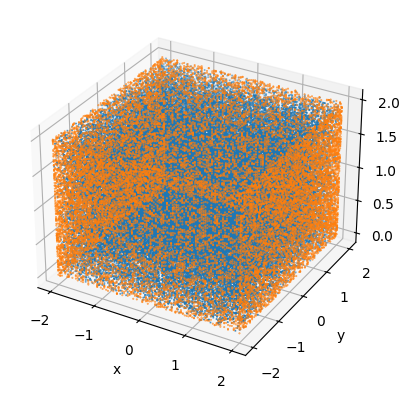

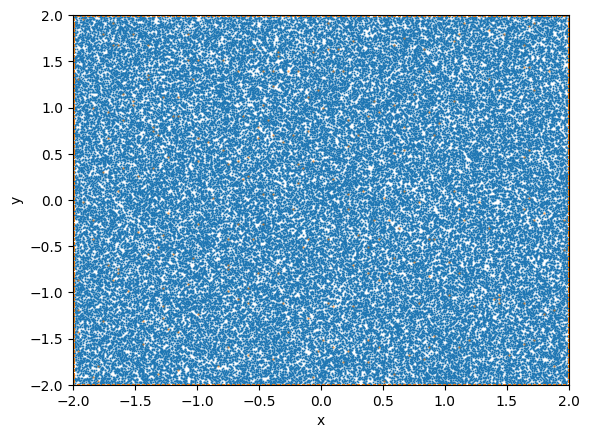

数据点总数: 100000


In [41]:
############### USER INPUT ##################


# Data-points
N_u = 20000
# Collocation-points
N_f = 80000
# FNN size
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Activation function
activation_func = tf.keras.activations.tanh

# ADAM
tf_epochs = 500 # Epochs w/ ADAM
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
batch_size = 50000 # Full batch = N_u + N_f

f_param = 1.0
u_param = 1.0


# Load data
noise = 0.00

### User needs to input path location. For example: path = os.path.join("/folder/2D_ADE_Training_Data.mat") ###

path = os.path.join("2D_ADE_v4_renamed.mat")#### Path to 2D Training data ####
x, y, t, X, Y, T, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise)

TrainingDataPlotterForward(X_u_train, X_f, ub, lb)

In [42]:
# Creating the model and training
logger = Logger(frequency=1)
logger.set_error_fn(error)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, ub, lb, f_param, u_param, activation_func)

TensorFlow version: 2.18.0
Eager execution: True
GPU-accerelated: True


In [43]:
loss_history, adaptive_param_history = pinn.fit(X_f, X_u_train, u_train, tf_epochs, batch_size)


Training started


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 20)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,041 (11.88 KB)

 Trainable params: 3,041 (11.88 KB)

 Non-trainable params: 0 (0.00 B)

None
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:00:02  loss = 1.3029e-01  best loss = 1.3029e-01  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      1  elapsed = 00:00:03  loss = 7.1968e-02  best loss = 7.1968e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      2  elapsed = 00:00:03  loss = 4.2384e-02  best loss = 4.2384e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      3  elapsed = 00:00:04  loss = 4.3374e-02  best loss = 4.2384e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      4  elapsed = 00:00:04  loss = 4.2518e-02  best loss = 4.2384e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      5  elapsed = 00:00:05  loss = 3.8573e-02  best loss = 3.8573e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      6  elapsed = 00:00:06  loss = 2.6703e-02  best loss = 2.6703e-02  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      7  elapsed = 00:00:06  loss = 2.8146e-02  best los

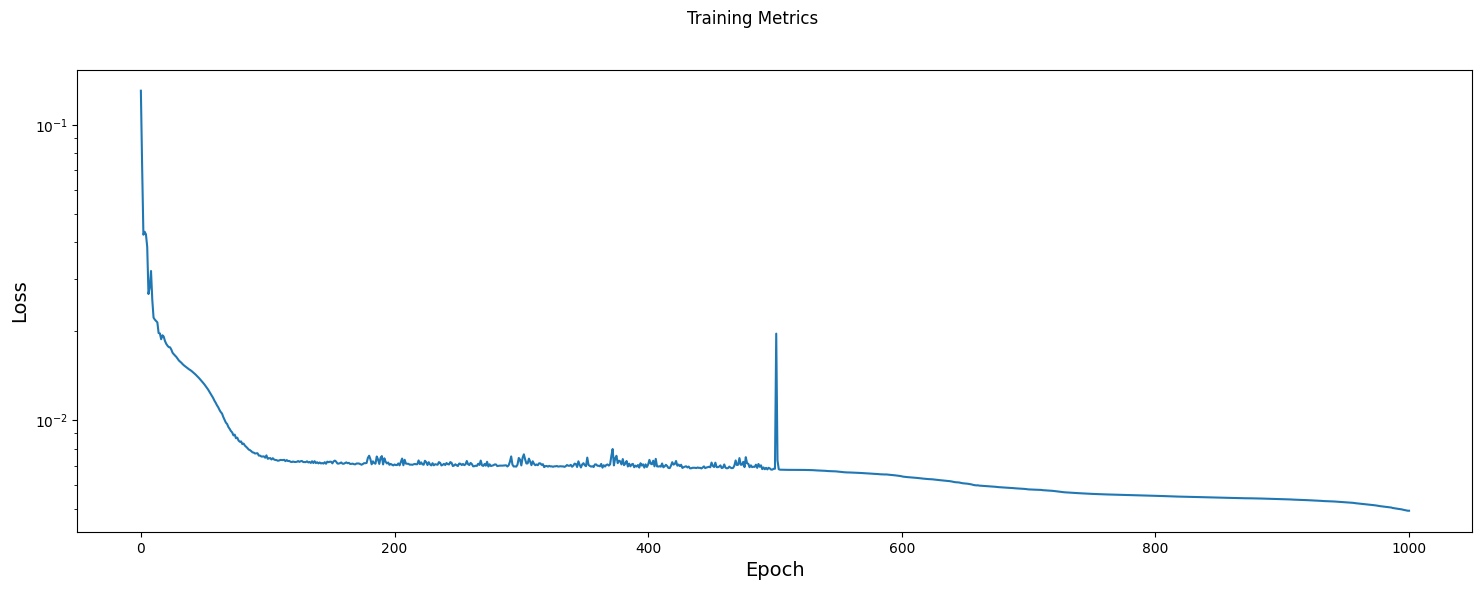

In [44]:
LossParameterPlotterForward(loss_history)

In [45]:
X_test, Y_test, u_star_plot, u_plot, u_train_pred, trained_weights = ExtractData(pinn, X_star, X_u_train, u_star)

In [46]:
#@title Error forward
def error_2():
    u_pred, _ = pinn.predict(X_f)
    u_starT = u_star.reshape(100,100,2000)
    u_starT = np.swapaxes(u_starT,0,1)
    u_starT = u_starT.flatten()[:,None]
    return np.linalg.norm(u_starT - u_pred, 2) / np.linalg.norm(u_starT, 2)

<ipython-input-5-ed69b6966c79>:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)


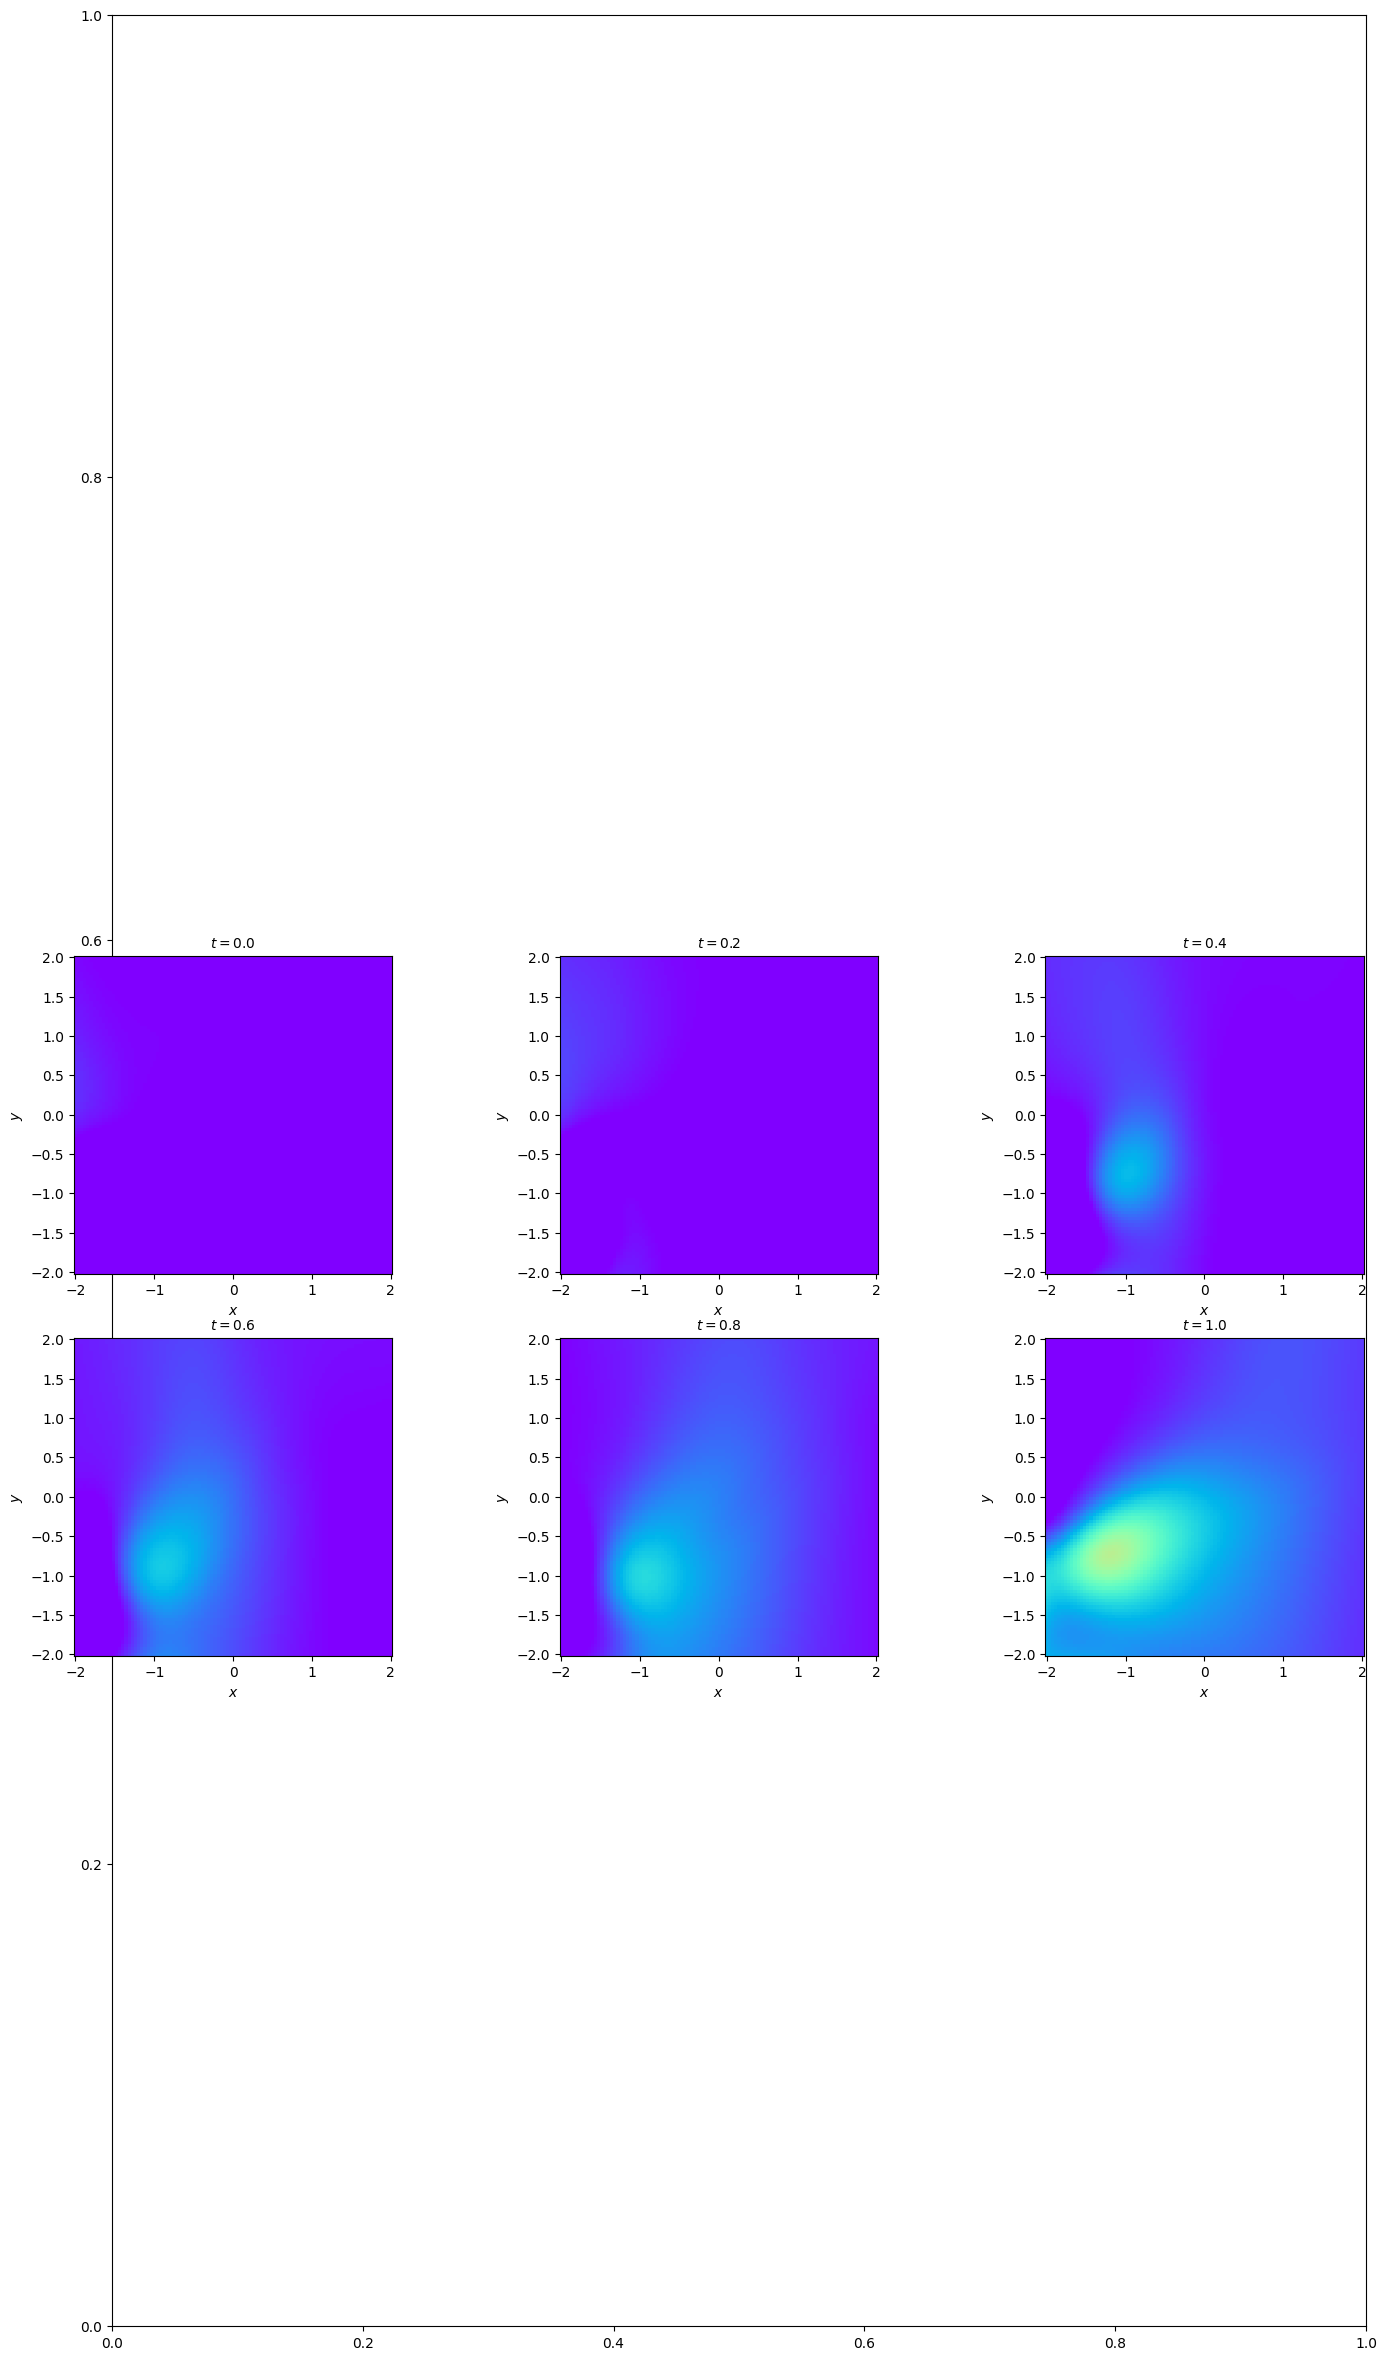

In [47]:
DiscretePlotter(t,X_test,Y_test,u_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow')

<ipython-input-5-ed69b6966c79>:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)


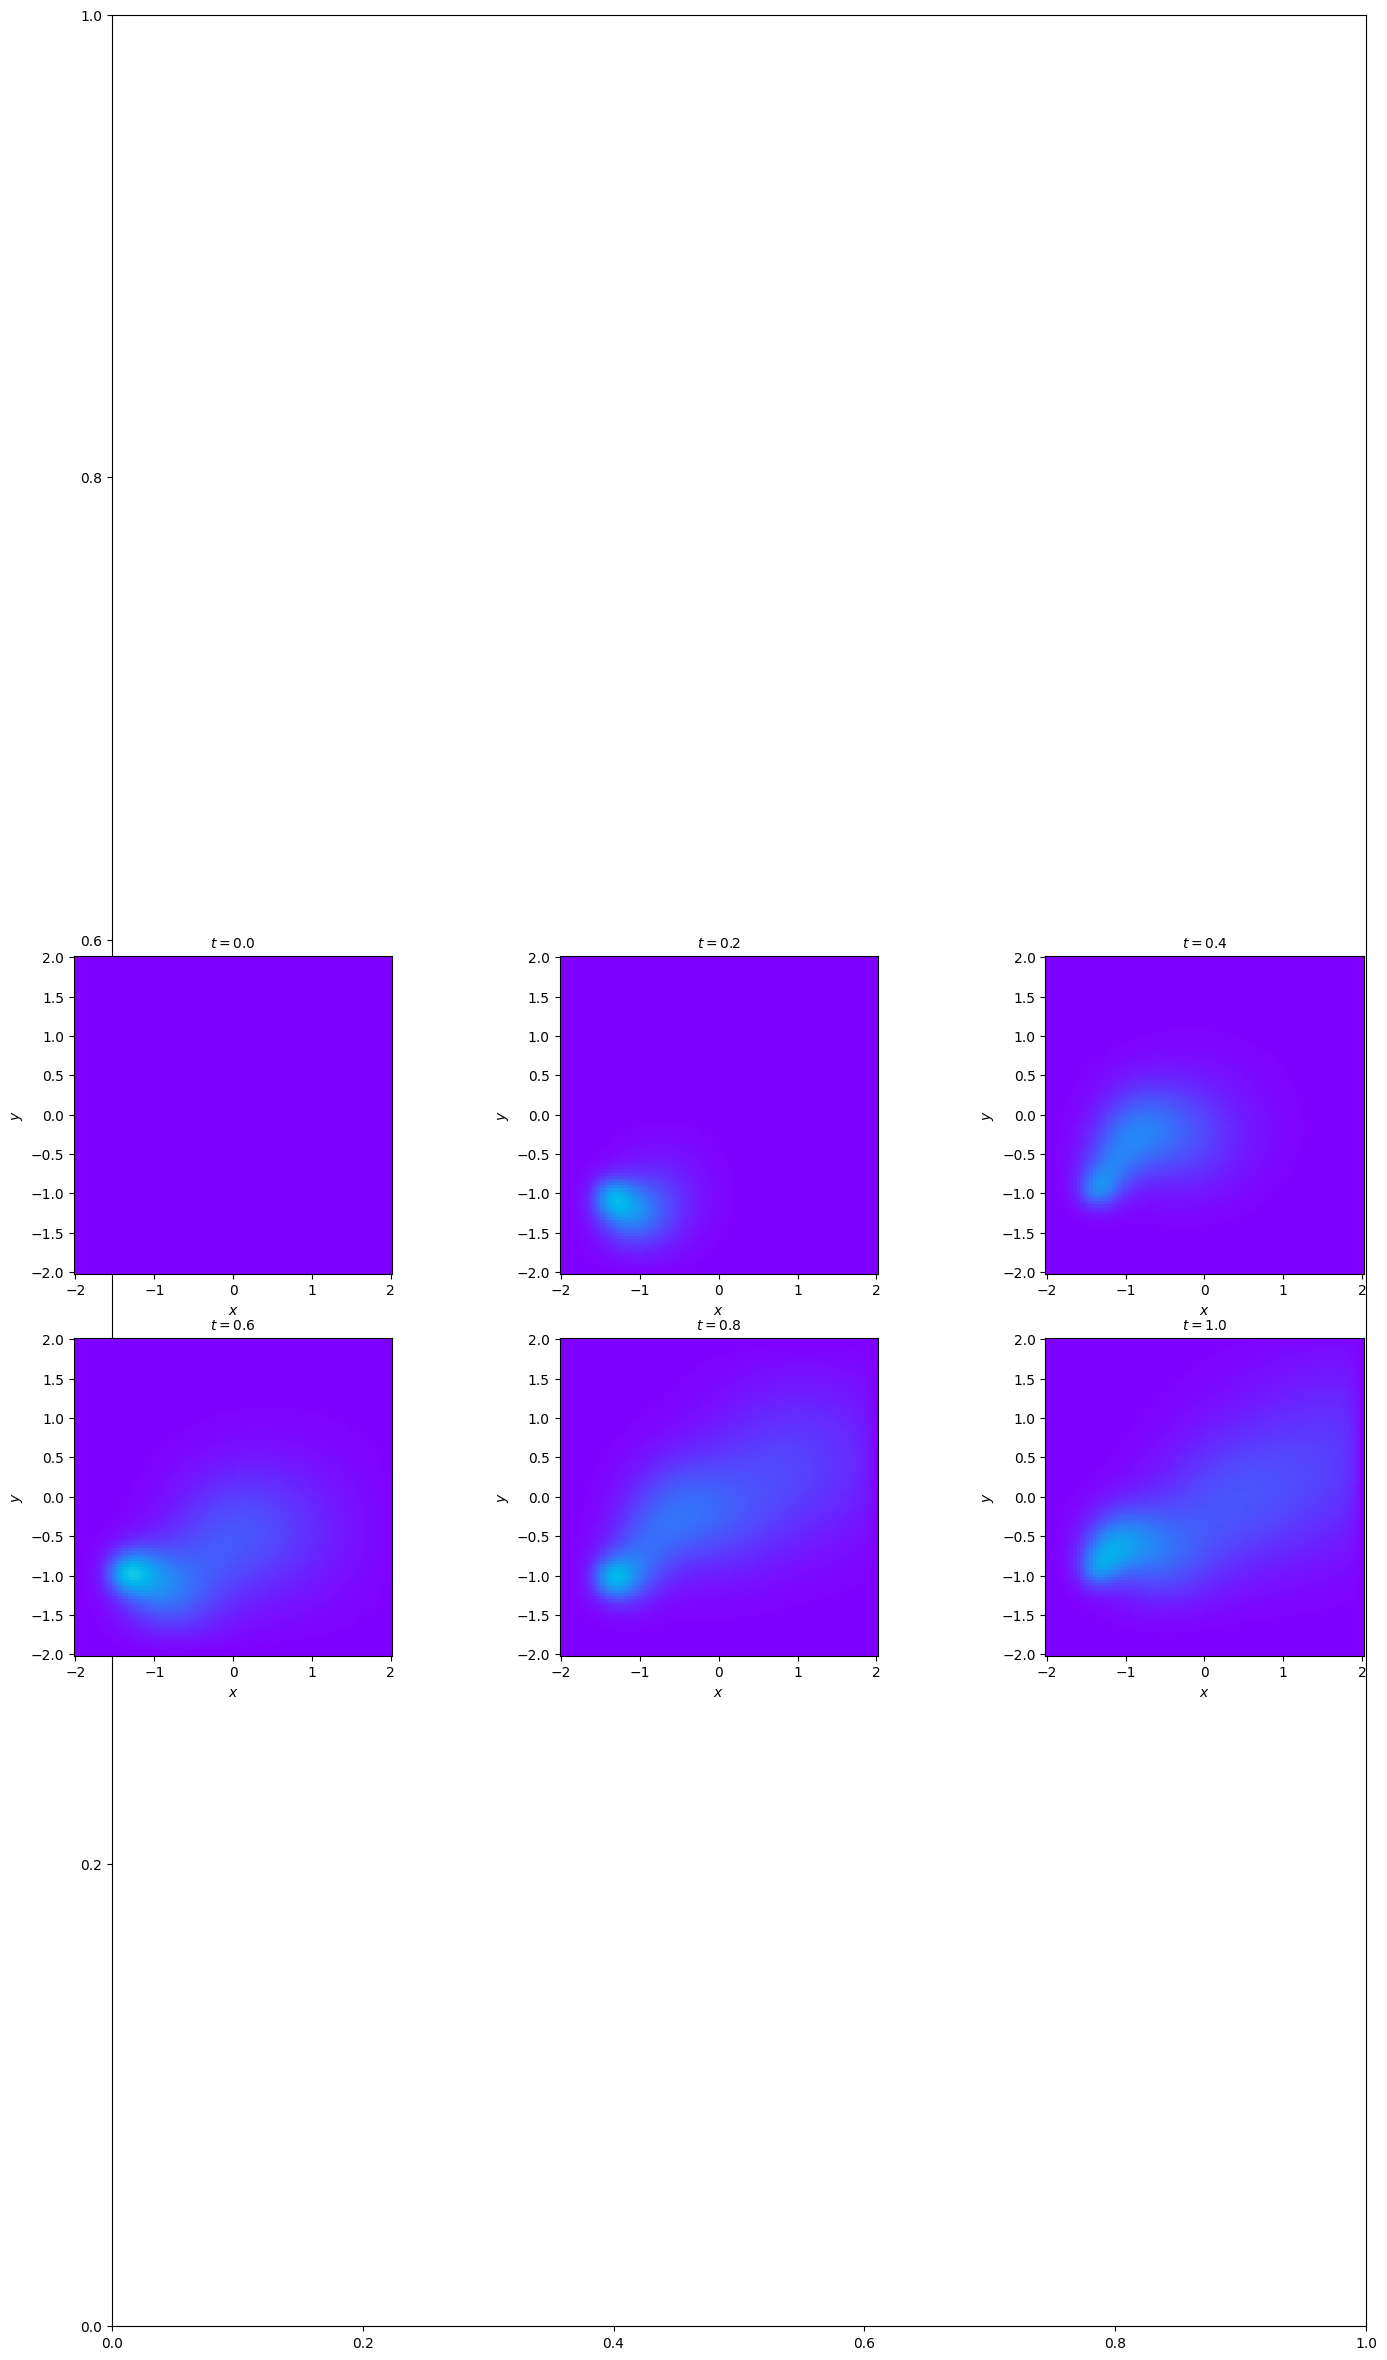

In [48]:

DiscretePlotter(t,X_test,Y_test,u_star_plot,ub,zmax=0.3,zmin=0.0,cmap='rainbow')

In [38]:
def ComparePredictionWithTruth(t, X_test, Y_test, u_star_plot, u_plot, ub):
    """
    比较PINN预测与真实解

    参数:
    t - 时间数组
    X_test - x坐标网格
    Y_test - y坐标网格
    u_star_plot - 真实解，维度为[x, y, t]
    u_plot - PINN预测解，维度为[x, y, t]
    ub - 上边界值，用于确定时间范围
    """
    N_t = t.shape[0]
    Lt = ub[2]
    # 选择几个时间点进行比较
    t0 = 0; t1 = Lt/5; t2 = 2*Lt/5; t3 = 3*Lt/5; t4 = 4*Lt/5; t5 = 5*Lt/5
    N0 = np.int32(np.ceil((t0*N_t)/Lt))
    N1 = np.int32(np.ceil((t1*N_t)/Lt))
    N2 = np.int32(np.ceil((t2*N_t)/Lt))
    N3 = np.int32(np.ceil((t3*N_t)/Lt))
    N4 = np.int32(np.ceil((t4*N_t)/Lt))
    N5 = np.int32(np.floor((t5*N_t-1)/Lt))

    time_points = [N0, N1, N2, N3, N4, N5]

    for i, n in enumerate(time_points):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 绘制真实解
        im0 = axes[0].pcolor(X_test, Y_test, u_star_plot[:,:,n], cmap='viridis')
        axes[0].set_title(f'真实解 (t = {t[n,0]:.2f})')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('y')
        fig.colorbar(im0, ax=axes[0])

        # 绘制PINN预测
        im1 = axes[1].pcolor(X_test, Y_test, u_plot[:,:,n], cmap='viridis')
        axes[1].set_title(f'PINN预测 (t = {t[n,0]:.2f})')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('y')
        fig.colorbar(im1, ax=axes[1])

        # 绘制误差
        error = np.abs(u_star_plot[:,:,n] - u_plot[:,:,n])
        im2 = axes[2].pcolor(X_test, Y_test, error, cmap='jet')
        axes[2].set_title(f'绝对误差 (t = {t[n,0]:.2f})')
        axes[2].set_xlabel('x')
        axes[2].set_ylabel('y')
        fig.colorbar(im2, ax=axes[2])

        plt.tight_layout()
        plt.show()

        # 计算并显示L2相对误差
        l2_error = np.sqrt(np.mean(np.square(error))) / np.sqrt(np.mean(np.square(u_star_plot[:,:,n])))
        max_error = np.max(error)
        print(f'时间 t = {t[n,0]:.2f}: L2相对误差 = {l2_error:.4e}, 最大绝对误差 = {max_error:.4e}')

    # 计算整体L2相对误差
    total_error = np.sqrt(np.mean(np.square(u_star_plot - u_plot))) / np.sqrt(np.mean(np.square(u_star_plot)))
    print(f'\n整体L2相对误差: {total_error:.4e}')

In [39]:
def PlotErrorOverTime(t, u_star_plot, u_plot):
    """
    绘制L2相对误差随时间的变化

    参数:
    t - 时间数组
    u_star_plot - 真实解，维度为[x, y, t]
    u_plot - PINN预测解，维度为[x, y, t]
    """
    N_t = t.shape[0]
    l2_errors = np.zeros(N_t)

    for i in range(N_t):
        error = np.abs(u_star_plot[:,:,i] - u_plot[:,:,i])
        l2_errors[i] = np.sqrt(np.mean(np.square(error))) / np.sqrt(np.mean(np.square(u_star_plot[:,:,i] + 1e-10)))

    plt.figure(figsize=(10, 6))
    plt.semilogy(t, l2_errors)
    plt.grid(True, which="both", ls="--")
    plt.xlabel('时间')
    plt.ylabel('L2相对误差')
    plt.title('PINN预测误差随时间的变化')
    plt.tight_layout()
    plt.show()

    print(f'平均L2相对误差: {np.mean(l2_errors):.4e}')
    print(f'最大L2相对误差: {np.max(l2_errors):.4e}')
    print(f'最小L2相对误差: {np.min(l2_errors):.4e}')

<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 32477 (\N{CJK UNIFIED IDEOGRAPH-7EDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-9137c5cac510>:51: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from

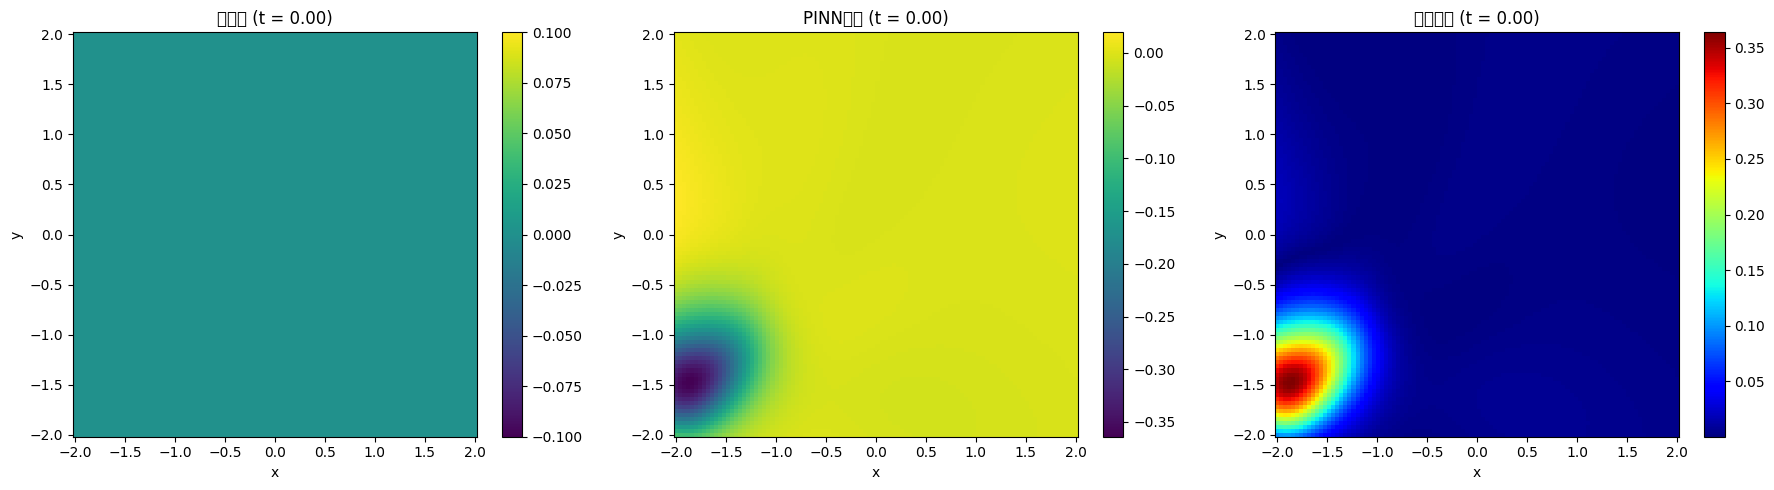

<ipython-input-38-9137c5cac510>:55: RuntimeWarning: divide by zero encountered in scalar divide
  l2_error = np.sqrt(np.mean(np.square(error))) / np.sqrt(np.mean(np.square(u_star_plot[:,:,n])))


时间 t = 0.00: L2相对误差 = inf, 最大绝对误差 = 3.6397e-01


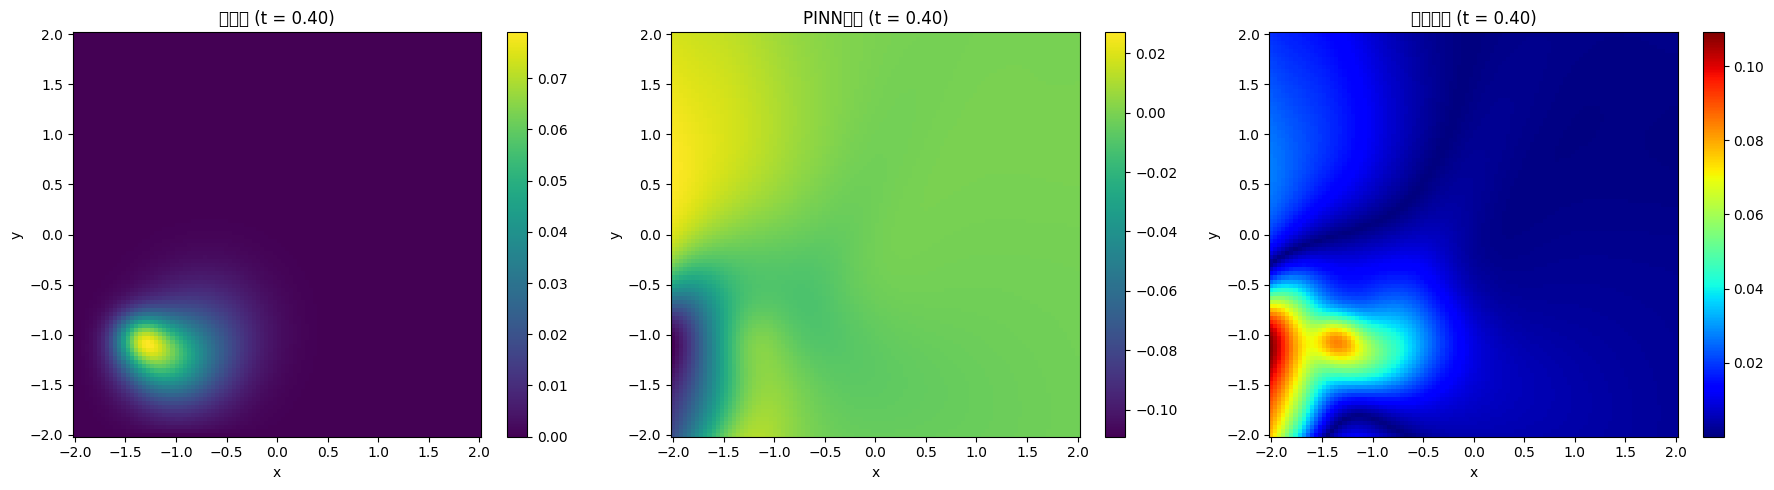

时间 t = 0.40: L2相对误差 = 1.9955e+00, 最大绝对误差 = 1.0916e-01


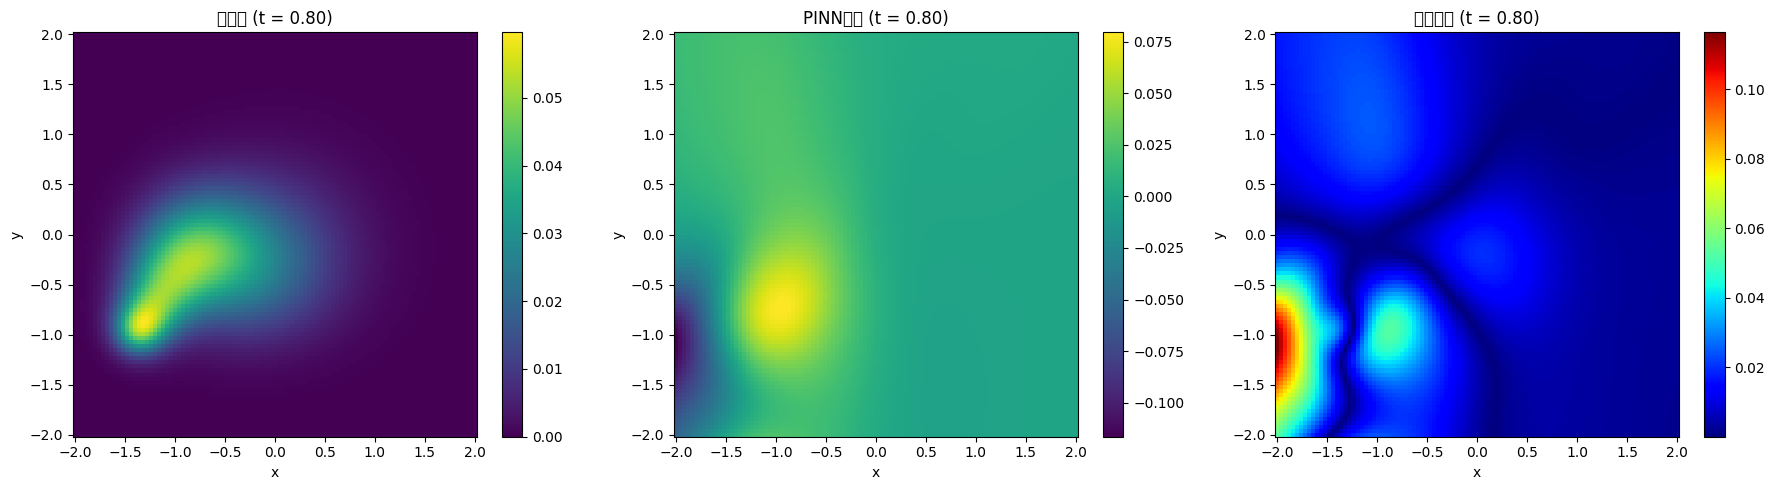

时间 t = 0.80: L2相对误差 = 1.4523e+00, 最大绝对误差 = 1.1644e-01


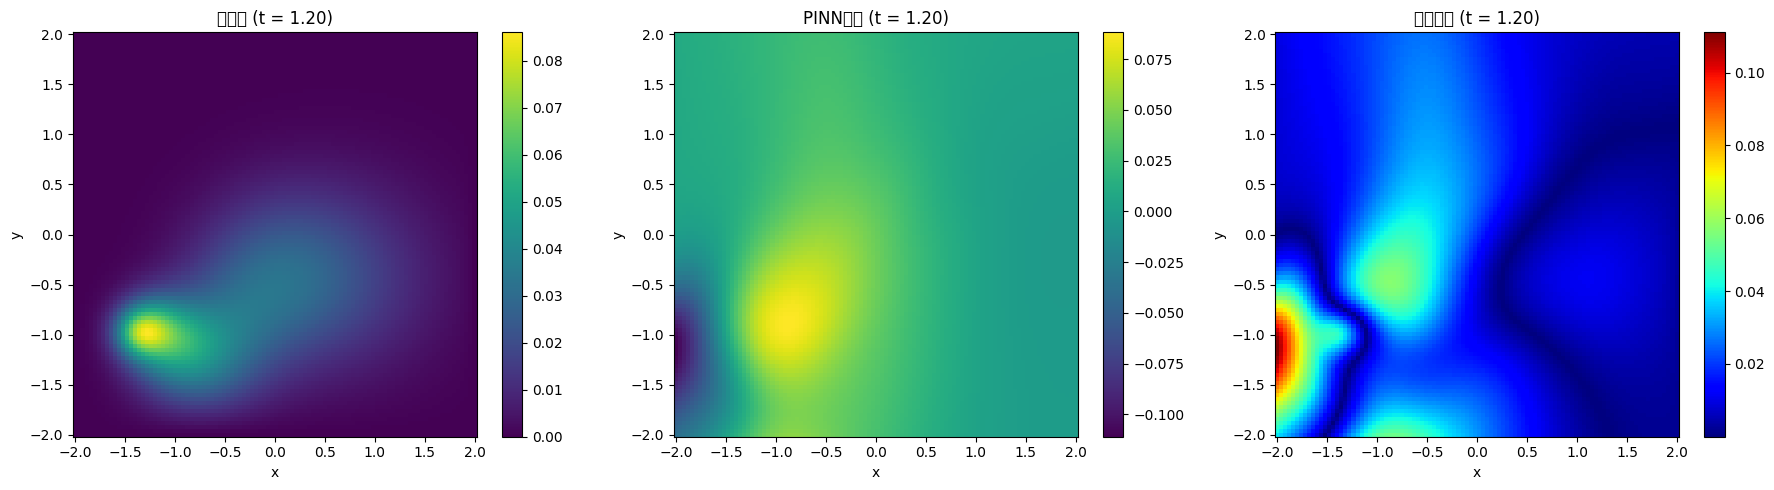

时间 t = 1.20: L2相对误差 = 1.4354e+00, 最大绝对误差 = 1.1104e-01


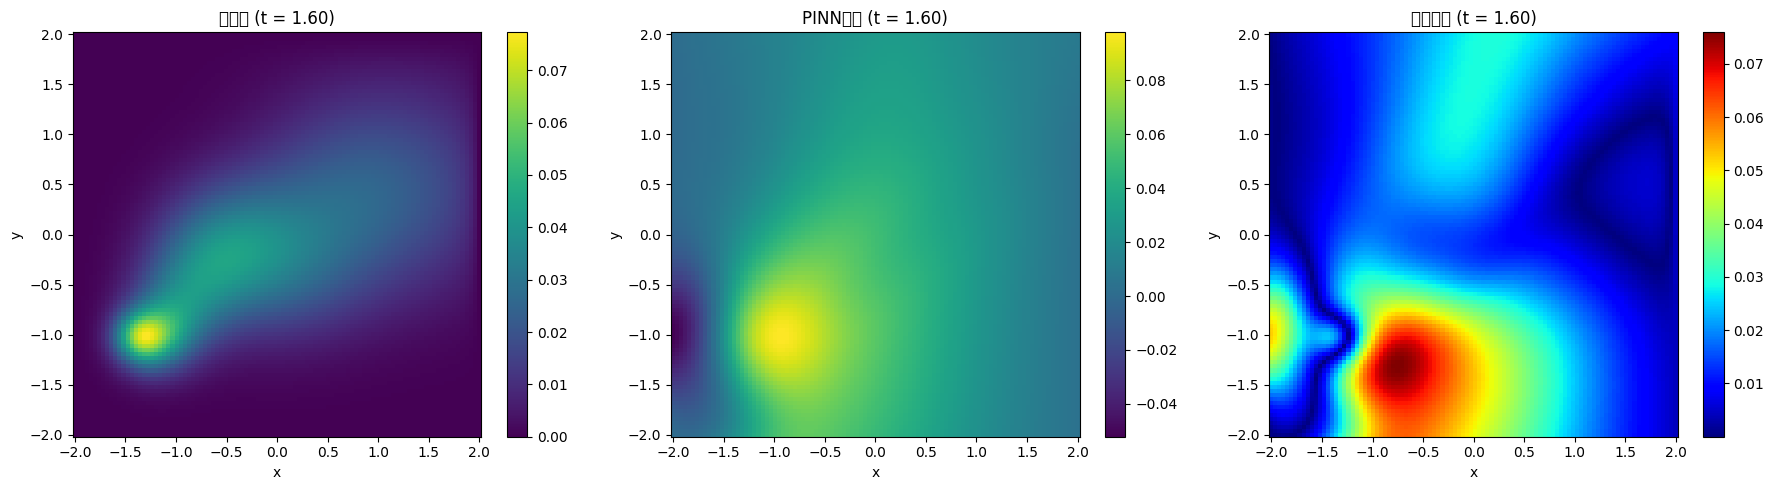

时间 t = 1.60: L2相对误差 = 1.5154e+00, 最大绝对误差 = 7.5891e-02


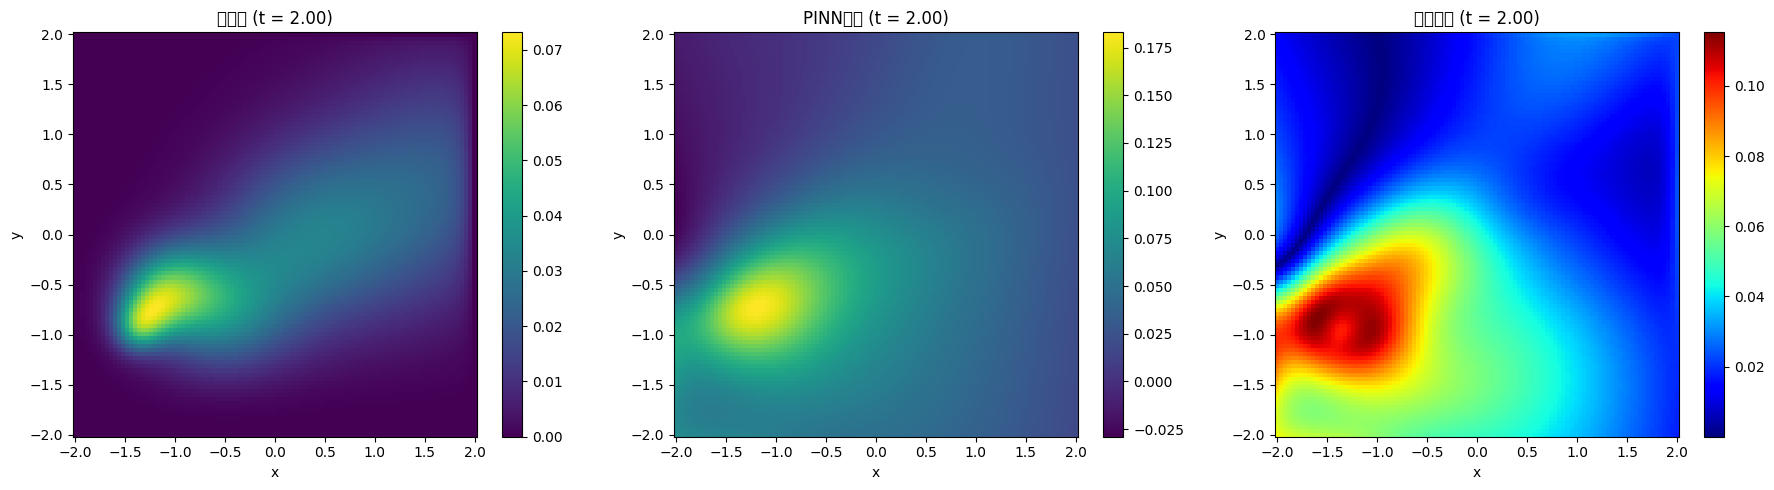

时间 t = 2.00: L2相对误差 = 2.4392e+00, 最大绝对误差 = 1.1529e-01

整体L2相对误差: 1.9282e+00


<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-39-c35d693a0039>:23: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from

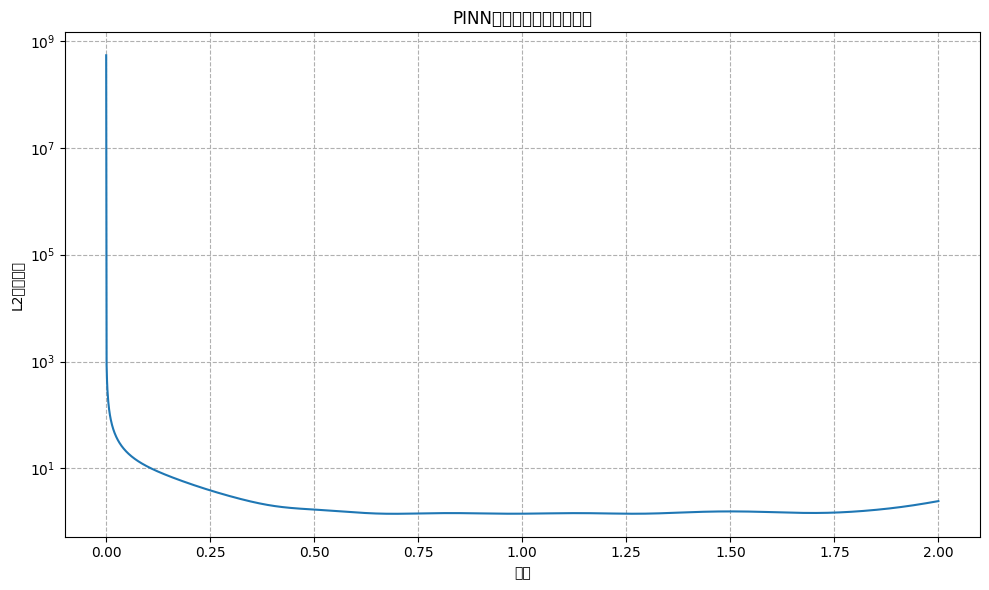

平均L2相对误差: 2.6961e+05
最大L2相对误差: 5.3922e+08
最小L2相对误差: 1.4119e+00


In [49]:
# 假设pinn是您训练好的模型
X_test, Y_test, u_star_plot, u_plot, u_train_pred, trained_weights = ExtractData(pinn, X_star, X_u_train, u_star)

# 比较预测结果与真实解
ComparePredictionWithTruth(t, X_test, Y_test, u_star_plot, u_plot, ub)

# 绘制误差随时间的变化
PlotErrorOverTime(t, u_star_plot, u_plot)

In [ ]:
savemat('PINNresults2DForwardFullbatchLBFGSAdapt.mat', {'u_pred': u_plot, 'u_true': u_star_plot, 'loss_history': loss_history,
                           'X_f':X_f, 'X_u_train': X_u_train, 'u_train': u_train, 'u_train_pred': u_train_pred, 'X': X_test, 'Y': Y_test,
                           'layers': layers, 'noise': noise, 'u_param': u_param, 'f_param': f_param, 'tf_epochs': tf_epochs, 'mini_batch_size': batch_size,
                           'adaptive_param': adaptive_param_history})